# Comparing Bouygues data pre & post trigger

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.stats import norm, t, ttest_ind, ttest_rel

1. [Series](#Series)    
2. [Play More](#Play-More)

# Series
### Load Data

In [58]:
series = pd.read_excel('query_result (64).xls')
series['date'] = series.timestamp.apply(lambda x: datetime.fromtimestamp(x/1000))
print len(series), 'records'
series.sort_values('customernumber', ascending=False).head()

3628 records


,customernumber,timestamp,programcrid,programseriesname,sessionrecordduration,date
2730,1029981160,1492552700000,crid://telenet.be/AA/TN00036628_02_0005-OSNL-SD,Ordinary Lies,37.850000,2017-04-18 23:58:20
2731,1029981160,1492549286000,crid://telenet.be/AA/TN00036628_02_0004-OSNL-SD,Ordinary Lies,23.116667,2017-04-18 23:01:26
2347,1029981160,1492381705000,crid://telenet.be/AA/TN00036628_02_0002-OSNL-SD,Ordinary Lies,48.150000,2017-04-17 00:28:25
2348,1029981160,1492380671000,crid://telenet.be/AA/TN00036628_02_0001-OSNL-SD,Ordinary Lies,17.133333,2017-04-17 00:11:11
2349,1029981160,1492304022000,crid://telenet.be/AA/TN00036628_02_0001-OSNL-SD,Ordinary Lies,51.616667,2017-04-16 02:53:42


In [59]:
header = ['customernumber', 'group', 'series', 'maildate']
mails = pd.read_excel('eval OOC triggers mail.xlsx', sheetname=2, names=header)
print len(mails), 'records'
mails.tail()

201 records


,customernumber,group,series,maildate
196,264411488,test,Ordinary Lies,2017-04-27
197,592780033,test,Ordinary Lies,2017-04-27
198,663266802,test,Ordinary Lies,2017-04-27
199,671609509,test,Ordinary Lies,2017-04-27
200,683208786,test,Ordinary Lies,2017-04-27


In [144]:
data = pd.merge(mails, series, on='customernumber')
data = data[data.series == data.programseriesname]
data = data[['customernumber', 'group', 'series', 'maildate', 'date', 'sessionrecordduration']]
print len(data), 'records'
data.sort_values('date', ascending=False).head()

3611 records


,customernumber,group,series,maildate,date,sessionrecordduration
485,723149245,test,Black-ish,2017-04-21,2017-04-30 23:42:58,20.716667
483,723149245,test,Black-ish,2017-04-21,2017-04-30 23:22:23,20.500000
482,723149245,test,Black-ish,2017-04-21,2017-04-30 23:01:40,20.633333
484,723149245,test,Black-ish,2017-04-21,2017-04-30 22:40:51,20.716667
493,723149245,test,Black-ish,2017-04-21,2017-04-30 22:26:00,14.566667


### Retrieve viewing counts, minutes watched and averages

Viewings splitted pre and post trigger

In [145]:
pre = data[(data.maildate - data.date) > pd.Timedelta(0)]
post = data[(data.maildate - data.date) <= pd.Timedelta(0)]

Number of viewings and total minutes watched grouped per customer

In [146]:
pre = pre.groupby(['customernumber']).agg({'group':'min', 'customernumber':'count', 'sessionrecordduration':'sum'})
post = post.groupby(['customernumber']).agg({'group':'min', 'customernumber':'count', 'sessionrecordduration':'sum'})

Include average minutes per viewing

In [147]:
pre['average'] = pre.sessionrecordduration / pre.customernumber
post['average'] = post.sessionrecordduration / post.customernumber
post.head()

,group,customernumber,sessionrecordduration,average
customernumber,,,,
3070553,test,2,41.433333,20.716667
10664542,test,4,82.300000,20.575000
12230585,test,9,185.283333,20.587037
14710250,test,7,143.216667,20.459524
19657351,control,4,77.516667,19.379167


Merge pre and post to include zero values per customer

In [148]:
counts = pd.merge(pre, post, left_index=True, right_index=True, how='outer').fillna(0)
counts.drop('group_y', 1, inplace=True)
counts.columns=['group', 'precount', 'preminutes', 'preaverage', 'postcount', 'postminutes', 'postaverage']
counts.head(10)

,group,precount,preminutes,preaverage,postcount,postminutes,postaverage
customernumber,,,,,,,
3070553,test,29,635.850000,21.925862,2.0,41.433333,20.716667
5748056,test,28,521.250000,18.616071,0.0,0.000000,0.000000
8823360,test,6,152.800000,25.466667,0.0,0.000000,0.000000
10664542,test,34,681.316667,20.038725,4.0,82.300000,20.575000
12230585,test,13,246.366667,18.951282,9.0,185.283333,20.587037
13607581,control,6,124.000000,20.666667,0.0,0.000000,0.000000
14710250,test,8,160.750000,20.093750,7.0,143.216667,20.459524
15678735,test,5,166.866667,33.373333,0.0,0.000000,0.000000
16645503,test,6,257.233333,42.872222,0.0,0.000000,0.000000


### Retrieve values

In [149]:
# To Include 0 values
pretestcount = counts[counts.group=='test'].precount
precontrolcount = counts[counts.group=='control'].precount
posttestcount = counts[counts.group=='test'].postcount
postcontrolcount = counts[counts.group=='control'].postcount

pretestminutes = counts[counts.group=='test'].preminutes
precontrolminutes = counts[counts.group=='control'].preminutes
posttestminutes = counts[counts.group=='test'].postminutes
postcontrolminutes = counts[counts.group=='control'].postminutes

pretestaverage = counts[counts.group=='test'].preaverage
precontrolaverage = counts[counts.group=='control'].preaverage
posttestaverage = counts[counts.group=='test'].postaverage
postcontrolaverage = counts[counts.group=='control'].postaverage

# To exclude 0 values
pretestcount = pre[pre.group=='test'].customernumber
precontrolcount = pre[pre.group=='control'].customernumber
posttestcount = post[post.group=='test'].customernumber
postcontrolcount = post[post.group=='control'].customernumber

pretestminutes = pre[pre.group=='test'].sessionrecordduration
precontrolminutes = pre[pre.group=='control'].sessionrecordduration
posttestminutes = post[post.group=='test'].sessionrecordduration
postcontrolminutes = post[post.group=='control'].sessionrecordduration

pretestaverage = pre[pre.group=='test'].average
precontrolaverage = pre[pre.group=='control'].average
posttestaverage = post[post.group=='test'].average
postcontrolaverage = post[post.group=='control'].average

Check

In [150]:
print (sum(pretestcount) + sum(precontrolcount) + sum(postcontrolcount) + sum(posttestcount), len(data))
print (sum(pretestminutes) + sum(precontrolminutes) + sum(postcontrolminutes) + sum(posttestminutes), sum(data.sessionrecordduration))
print len(pretestaverage), len(precontrolaverage), len(posttestaverage), len(postcontrolaverage)

(3611, 3611)
(73911.933333341207, 73911.93333334144)
154 30 63 14


### Comparing Counts

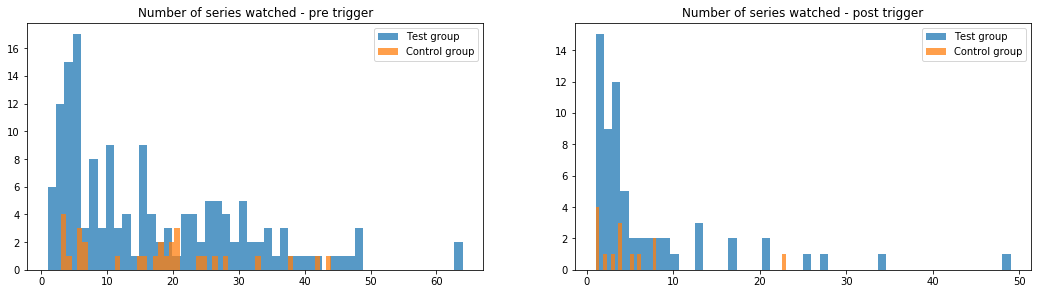

In [99]:
x = np.linspace(0,1, num=1000)
fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(221); ax2 = fig.add_subplot(222)

ax1.hist(pretestcount, bins=50, alpha=0.75, label='Test group')
ax1.hist(precontrolcount, bins=50, alpha=0.75, label='Control group')
ax2.hist(posttestcount, bins=50, alpha=0.75, label='Test group')
ax2.hist(postcontrolcount, bins=50, alpha=0.75, label='Control group')

ax1.legend(); ax2.legend()
ax1.set_title('Number of series watched - pre trigger')
ax2.set_title('Number of series watched - post trigger')
plt.show()

Independent t-test between test & control pre-trigger should fail to reject null hypothesis as neither received mails. Fails to reject H0.

In [100]:
print ttest_ind(pretestcount, precontrolcount)
print 'Critical T values:', t.interval(.95, len(pretestcount) + len(precontrolcount) - 2)

Ttest_indResult(statistic=-0.25623210434201216, pvalue=0.79806101233390092)
Critical T values: (-1.9730840773322158, 1.9730840773322158)


Independent t-test between test & control post-trigger should reject null hypothesis as one group received mails. Fails to reject H0.

In [101]:
print ttest_ind(posttestcount, postcontrolcount)
print 'Critical T value:', t.interval(.95, len(posttestcount) + len(postcontrolcount) - 2)

Ttest_indResult(statistic=0.63210355511237049, pvalue=0.52924143590011252)
Critical T value: (-1.9921021536898653, 1.9921021536898653)


### Comparing Minutes

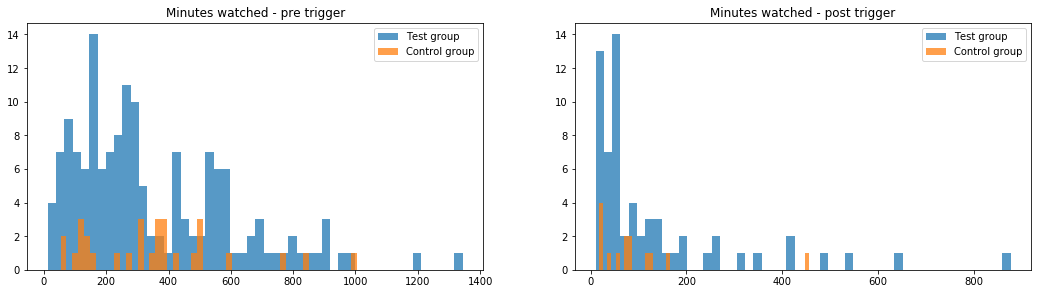

In [104]:
x = np.linspace(0,1, num=1000)
fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(221); ax2 = fig.add_subplot(222)

ax1.hist(pretestminutes, bins=50, alpha=0.75, label='Test group')
ax1.hist(precontrolminutes, bins=50, alpha=0.75, label='Control group')
ax2.hist(posttestminutes, bins=50, alpha=0.75, label='Test group')
ax2.hist(postcontrolminutes, bins=50, alpha=0.75, label='Control group')

ax1.legend(); ax2.legend()
ax1.set_title('Minutes watched - pre trigger')
ax2.set_title('Minutes watched - post trigger')
plt.show()

Independent t-test between test & control pre-trigger should fail to reject null hypothesis as neither received mails. Fails to reject H0.

In [105]:
print ttest_ind(pretestminutes, precontrolminutes)
print 'Critical T values:', t.interval(.95, len(pretestminutes) + len(precontrolminutes) - 2)

Ttest_indResult(statistic=-0.1466365482075673, pvalue=0.88358120332375623)
Critical T values: (-1.9730840773322158, 1.9730840773322158)


Independent t-test between test & control post-trigger should reject null hypothesis as one group received mails. Fails to reject H0.

In [106]:
print ttest_ind(posttestminutes, postcontrolminutes)
print 'Critical T value:', t.interval(.95, len(posttestminutes) + len(postcontrolminutes) - 2)

Ttest_indResult(statistic=0.72941396325706476, pvalue=0.46802039023171926)
Critical T value: (-1.9921021536898653, 1.9921021536898653)


### Comparing Averages

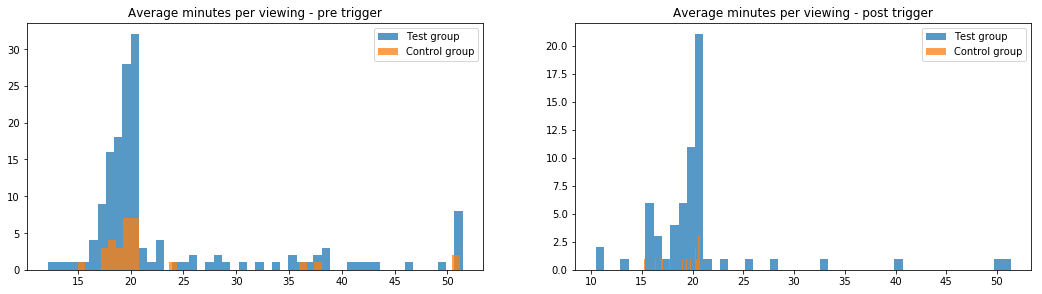

In [109]:
x = np.linspace(0,1, num=1000)
fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(221); ax2 = fig.add_subplot(222)

ax1.hist(pretestaverage, bins=50, alpha=0.75, label='Test group')
ax1.hist(precontrolaverage, bins=50, alpha=0.75, label='Control group')
ax2.hist(posttestaverage, bins=50, alpha=0.75, label='Test group')
ax2.hist(postcontrolaverage, bins=50, alpha=0.75, label='Control group')

ax1.legend(); ax2.legend()
ax1.set_title('Average minutes per viewing - pre trigger')
ax2.set_title('Average minutes per viewing - post trigger')
plt.show()

Independent t-test between test & control pre-trigger should fail to reject null hypothesis as neither received mails. Fails to reject H0.

In [110]:
print ttest_ind(pretestaverage, precontrolaverage)
print 'Critical T values:', t.interval(.95, len(pretestaverage) + len(precontrolaverage) - 2)

Ttest_indResult(statistic=0.47017633773097917, pvalue=0.63879195385176657)
Critical T values: (-1.9730840773322158, 1.9730840773322158)


Independent t-test between test & control post-trigger should reject null hypothesis as one group received mails. Fails to reject H0.

In [111]:
print ttest_ind(posttestaverage, postcontrolaverage)
print 'Critical T value:', t.interval(.95, len(posttestaverage) + len(postcontrolaverage) - 2)

Ttest_indResult(statistic=0.85611251521186893, pvalue=0.39466253135326246)
Critical T value: (-1.9921021536898653, 1.9921021536898653)


# Play More
### Load Data

In [114]:
playmore = pd.read_excel('query_result (63).xls')
print len(playmore), 'records'
playmore['date'] = playmore[['year', 'month', 'day']].apply(lambda s : datetime(*s), axis=1)
playmore.head()

17415 records


,customernumber,year,month,day,cnt_programs,sum_srd,date
0,12230585,2017,1,26,1,35.000000,2017-01-26
1,214177919,2017,1,15,3,72.933333,2017-01-15
2,214177919,2017,2,5,2,43.583333,2017-02-05
3,25594963,2017,1,6,2,113.750000,2017-01-06
4,47823121,2017,2,10,4,181.650000,2017-02-10


In [115]:
data = pd.merge(mails, playmore, on='customernumber', how='inner')
data = data[['customernumber', 'group', 'maildate', 'date', 'sum_srd']]
print len(data), 'records'
data.sort_values('date', ascending=False).head()

17415 records


,customernumber,group,maildate,date,sum_srd
11182,724766721,test,2017-04-21,2017-04-30,98.550000
11951,990003925,control,2017-04-27,2017-04-30,134.466667
15505,266575194,test,2017-04-21,2017-04-30,285.066667
13697,965559723,test,2017-04-21,2017-04-30,13.866667
1461,507305754,test,2017-04-21,2017-04-30,107.150000


### Retrieve viewing counts, minutes watched and averages

Viewings splitted pre and post trigger

In [116]:
pre = data[(data.maildate - data.date) > pd.Timedelta(0)]
post = data[(data.maildate - data.date) <= pd.Timedelta(0)]

Number of viewings and total minutes watched grouped per customer

In [117]:
pre = pre.groupby(['customernumber']).agg({'group':'min', 'customernumber':'count', 'sum_srd':'sum'})
post = post.groupby(['customernumber']).agg({'group':'min', 'customernumber':'count', 'sum_srd':'sum'})

Include average minutes per viewing

In [118]:
pre['average'] = pre.sum_srd / pre.customernumber
post['average'] = post.sum_srd / post.customernumber
post.head()

,group,customernumber,sum_srd,average
customernumber,,,,
3070553,test,4,535.250000,133.812500
5748056,test,4,753.033333,188.258333
8823360,test,10,4010.616667,401.061667
10664542,test,8,710.233333,88.779167
12230585,test,5,817.733333,163.546667


Merge pre and post to include zero values per customer

In [119]:
counts = pd.merge(pre, post, left_index=True, right_index=True, how='inner').fillna(0)
counts.drop('group_y', 1, inplace=True)
counts.columns=['group', 'precount', 'preminutes', 'preaverage', 'postcount', 'postminutes', 'postaverage']
counts.head(10)

,group,precount,preminutes,preaverage,postcount,postminutes,postaverage
customernumber,,,,,,,
3070553,test,89,13980.900000,157.088764,4,535.250000,133.812500
5748056,test,41,4846.150000,118.198780,4,753.033333,188.258333
8823360,test,108,46750.983333,432.879475,10,4010.616667,401.061667
10664542,test,91,9163.016667,100.692491,8,710.233333,88.779167
12230585,test,57,6945.566667,121.852047,5,817.733333,163.546667
13607581,control,95,15089.316667,158.834912,10,1933.516667,193.351667
14710250,test,102,13424.866667,131.616340,10,1798.400000,179.840000
15678735,test,98,17050.883333,173.988605,10,1001.600000,100.160000
16645503,test,99,24553.766667,248.017845,10,2104.166667,210.416667


### Retrieve values

In [120]:
# To Include 0 values
'''pretestcount = counts[counts.group=='test'].precount
precontrolcount = counts[counts.group=='control'].precount
posttestcount = counts[counts.group=='test'].postcount
postcontrolcount = counts[counts.group=='control'].postcount

pretestminutes = counts[counts.group=='test'].preminutes
precontrolminutes = counts[counts.group=='control'].preminutes
posttestminutes = counts[counts.group=='test'].postminutes
postcontrolminutes = counts[counts.group=='control'].postminutes

pretestaverage = counts[counts.group=='test'].preaverage
precontrolaverage = counts[counts.group=='control'].preaverage
posttestaverage = counts[counts.group=='test'].postaverage
postcontrolaverage = counts[counts.group=='control'].postaverage'''

# To exclude 0 values
pretestcount = pre[pre.group=='test'].customernumber
precontrolcount = pre[pre.group=='control'].customernumber
posttestcount = post[post.group=='test'].customernumber
postcontrolcount = post[post.group=='control'].customernumber

pretestminutes = pre[pre.group=='test'].sum_srd
precontrolminutes = pre[pre.group=='control'].sum_srd
posttestminutes = post[post.group=='test'].sum_srd
postcontrolminutes = post[post.group=='control'].sum_srd

pretestaverage = pre[pre.group=='test'].average
precontrolaverage = pre[pre.group=='control'].average
posttestaverage = post[post.group=='test'].average
postcontrolaverage = post[post.group=='control'].average

Check

In [121]:
print (sum(pretestcount) + sum(precontrolcount) + sum(postcontrolcount) + sum(posttestcount), len(data))
print (sum(pretestminutes) + sum(precontrolminutes) + sum(postcontrolminutes) + sum(posttestminutes), sum(data.sum_srd))
print len(pretestaverage), len(precontrolaverage), len(posttestaverage), len(postcontrolaverage)

(17415, 17415)
(3268857.7666666456, 3268857.7666666382)
155 32 151 33


### Comparing Averages

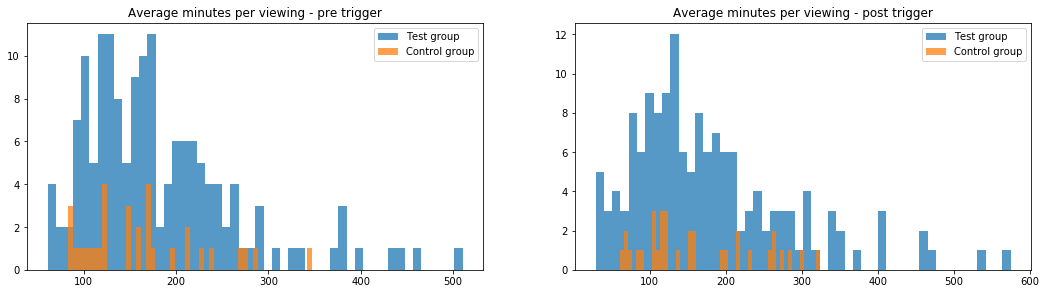

In [122]:
x = np.linspace(0,1, num=1000)
fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(221); ax2 = fig.add_subplot(222)

ax1.hist(pretestaverage, bins=50, alpha=0.75, label='Test group')
ax1.hist(precontrolaverage, bins=50, alpha=0.75, label='Control group')
ax2.hist(posttestaverage, bins=50, alpha=0.75, label='Test group')
ax2.hist(postcontrolaverage, bins=50, alpha=0.75, label='Control group')

ax1.legend(); ax2.legend()
ax1.set_title('Average minutes per viewing - pre trigger')
ax2.set_title('Average minutes per viewing - post trigger')
plt.show()

Independent t-test between test & control pre-trigger should fail to reject null hypothesis as neither received mails. Fails to reject H0.

In [123]:
print ttest_ind(pretestaverage, precontrolaverage)
print 'Critical T values:', t.interval(.95, len(pretestaverage) + len(precontrolaverage) - 2)

Ttest_indResult(statistic=1.0689680615480297, pvalue=0.2864768615565863)
Critical T values: (-1.9728699462074988, 1.9728699462074988)


Independent t-test between test & control post-trigger should reject null hypothesis as one group received mails. Fails to reject H0.

In [124]:
print ttest_ind(posttestaverage, postcontrolaverage)
print 'Critical T value:', t.interval(.95, len(posttestaverage) + len(postcontrolaverage) - 2)

Ttest_indResult(statistic=0.79562367006979107, pvalue=0.42728725369948606)
Critical T value: (-1.9730840773322158, 1.9730840773322158)
